<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/Correlation_gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime
from pykalman import KalmanFilter

In [3]:
data = pd.read_csv('/content/gold.csv')

In [4]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [5]:
del data['time']

In [6]:
data= data.set_index('date')

In [7]:
data=data['01-01-2018':]

In [8]:
data_subset = data[['close','GOLDBEES, NSE: Close']]

In [9]:
data_subset.tail(2)

,close,"GOLDBEES, NSE: Close"
date,,
08-08-2023,19611.25,50.560001
09-08-2023,19693.00,50.369999


In [10]:
data_subset.columns=['close','close1']

In [11]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])
columns=['India Nifty','Gold']
standard_df.columns=columns


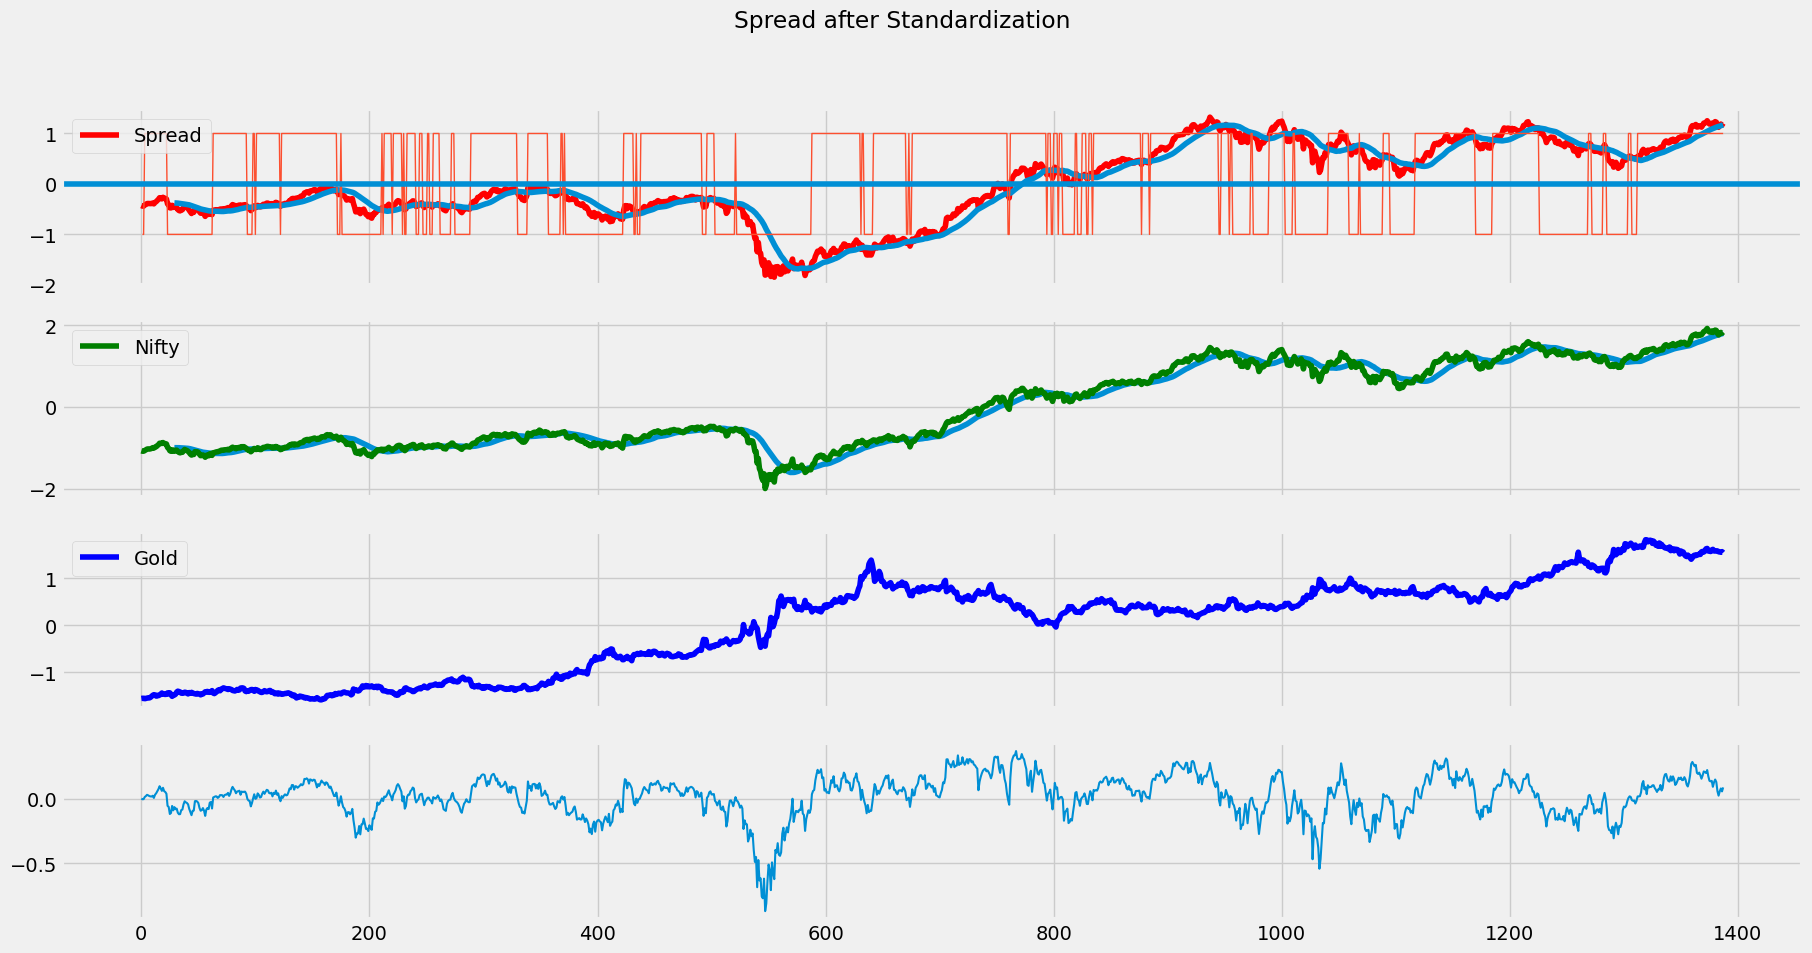

In [12]:
standard_df['diff']=standard_df['India Nifty']-standard_df['Gold']*0.41
standard_df['diff']=standard_df['diff'].fillna(method='ffill')
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(4,1,sharex=True)

ax[3].plot(standard_df['diff']-standard_df['diff'].ewm(span=35).mean(),linewidth=1.5)
ax[0].plot(standard_df['diff'],color='r',label='Spread')
ax[0].plot(standard_df['diff'].rolling(window=30).mean())
ax[0].plot(np.sign(standard_df['diff'].ewm(span=35).mean().diff()),linewidth=1)
ax[1].plot(standard_df['India Nifty'].rolling(window=30).mean())
ax[1].plot(standard_df['India Nifty'],color='g',label='Nifty')
ax[2].plot(standard_df['Gold'],color='b',label='Gold')
ax[0].axhline(y=0)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.suptitle('Spread after Standardization')
plt.show()

In [13]:
df = standard_df[['diff']]

In [14]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['diff'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())



In [15]:
spread= pd.DataFrame({'Date':df.index,'spread':(df['diff'].values - mean)})


In [16]:
spread=spread.set_index('Date')


In [17]:
df_new=pd.concat([df,spread['spread']],axis=1)


In [18]:
df_new['30 Day MA'] = df_new['spread'].rolling(window=50).mean()
# set .std(ddof=0) for population std instead of sample
df_new['30 Day STD'] = df_new['spread'].rolling(window=50).std()
df_new['Upper Band'] = df_new['30 Day MA'] + (df_new['30 Day STD'] *1.5)
df_new['Lower Band'] = df_new['30 Day MA'] - (df_new['30 Day STD'] *1.5)
df_new['boll_percent'] = (df_new['spread']-df_new['Lower Band'])/(df_new['Upper Band']-df_new['Lower Band'])
df_new['signal']=np.where(df_new['boll_percent']>0,1,0)

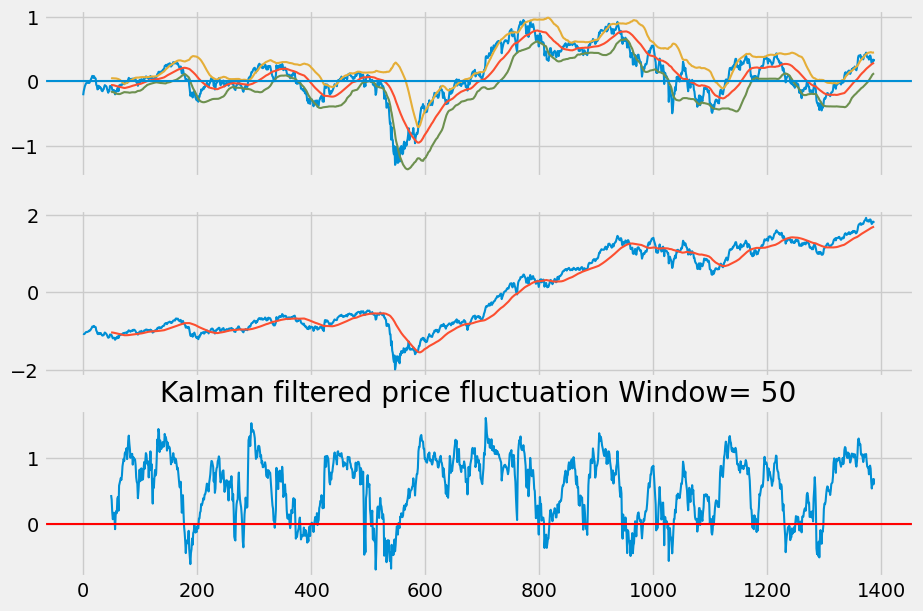

In [19]:
fig, ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-1800:],lw=1.5)
ax[0].axhline(y=0,lw=1.5)
#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation Window= 50")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[2].plot(df_new[['boll_percent']][-1800:],lw=1.5)
ax[2].axhline(y=0,color='r',lw=1.5)
ax[1].plot(standard_df[['India Nifty']][-1800:],lw=1.5)
ax[1].plot(standard_df[['India Nifty']][-1800:].rolling(window=50).mean(),lw=1.5)
plt.show()


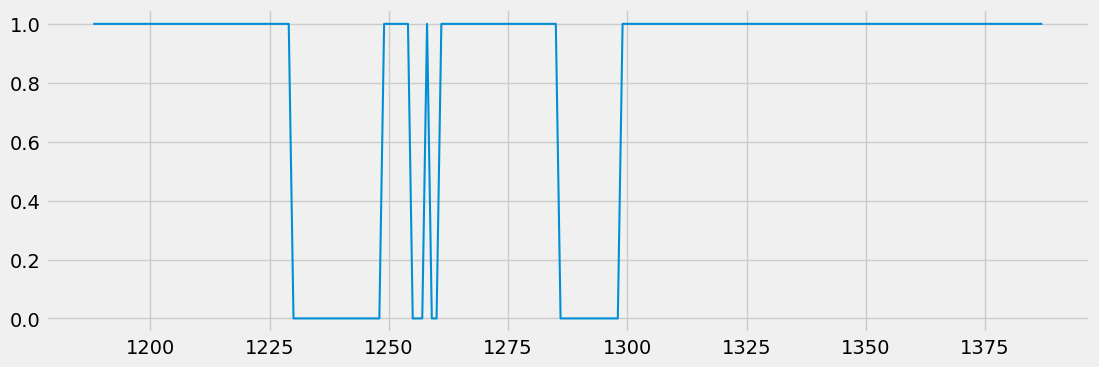

In [20]:
plt.figure(figsize=(12,4))
plt.plot(df_new['signal'][-200:],lw=1.5);

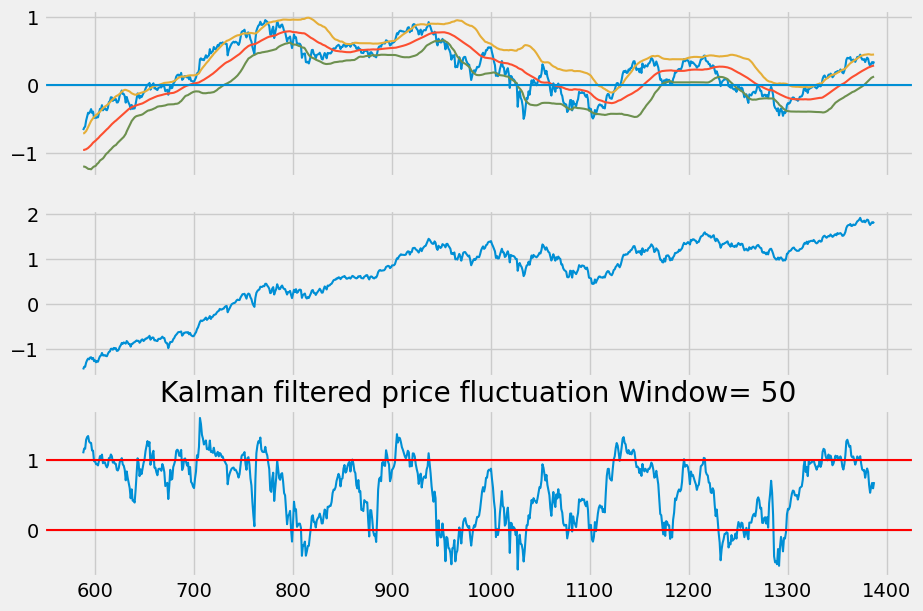

In [21]:
fig, ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-800:],lw=1.5)
ax[0].axhline(y=0,lw=1.5)
#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation Window= 50")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[2].plot(df_new[['boll_percent']][-800:],lw=1.5)
ax[2].axhline(y=0,color='r',lw=1.5)
ax[2].axhline(y=1,color='r',lw=1.5)
ax[1].plot(standard_df[['India Nifty']][-800:],lw=1.5)
plt.show()

Correlation for last 60 days is -41%


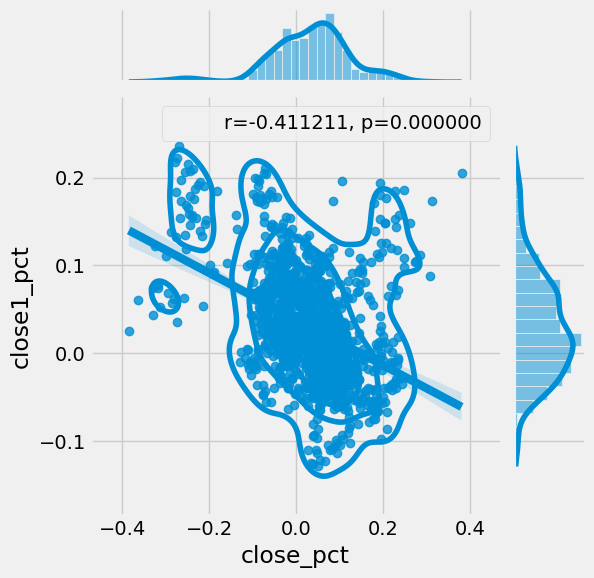

In [22]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
print(f'Correlation for last 60 days is {round(r*100)}%')
